# SP Procurement Data Investigation

11/16/2024

We are looking at the 2019-03 database bidding data available in GDrive. 

In [52]:
# load data
# GDrive: SPProcurement > PSP Data > bec_sample_201903
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv(
    "data/1_level_of_individual_bids_pregao_201903.csv", delimiter=";", low_memory=False
)
print(f"shape: {df.shape}")

# these are duplicates of other columns
df = df.drop(["cd_fase", "nr_apelido"], axis=1)

# load translations of columns, rename columns
bids_columns_translations = pd.read_csv("assets/bids_columns_translations.csv")
column_translation_mapping = dict(
    zip(
        bids_columns_translations.original_column,
        bids_columns_translations.translated_column,
    )
)
df = df.rename(columns=column_translation_mapping)
# these are the columns we think are relevant
# 'offer' is the unique identifier for a bid. but there are some offers that
# appear to be duplicates (very rare), we drop them
minimal_columns = [
    "id",  # auction ID
    "uge",  # buyer ID
    "supplier_name",  # bidder name
    "cr_status",  # qualification result
    "bidding",  # bidding time
    "sequence_item",  # item enumerator in auction
    "item",  # item code
    "class",  # more coarse item code
    "group",  # most coarse item code
    "detailed_description",  # offer result (e.g. confirmed, too high, etc.)
    "manufacturer_name",  # manufacturer name
    "offered_value",  # value of the bid
    "offer",  # unique identifier for a bid
]
df = df[minimal_columns].drop_duplicates(minimal_columns[:-1])
df["bidding"] = pd.to_datetime(df["bidding"], format="%Y-%m-%d %H:%M:%S.%f")
print(f"shape with minimal columns after dropping duplicates: {df.shape}")

# ids can be reused by different buyers, so we need to make them unique
df["id"] = df["id"].astype(str) + "_" + df["uge"].astype(str)

shape: (184102, 55)
shape with minimal columns after dropping duplicates: (183420, 13)


In [53]:
# how many auctions are there?
df.id.nunique()

1846

In [54]:
# how many buyers are there?
df.uge.nunique()

377

In [55]:
# how many unique bidders are there?
df.supplier_name.nunique()

3484

In [56]:
# how many unique items are there?
df.item.nunique()

5269

In [57]:
# how many total items were auctioned off?
df.groupby("id")["sequence_item"].nunique().sum()

9093

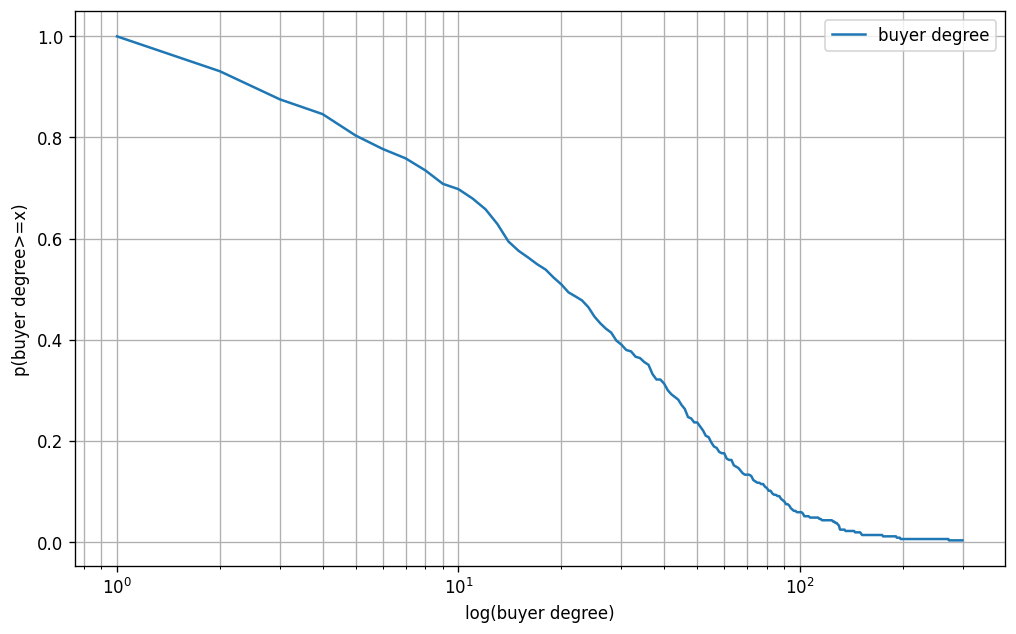

In [58]:
# what is the degree distribution graph of the buyers? ('uge')
# x-axis = degree of node
# y-axis = number of nodes with that degree or higher

from src.graph_utils import plot_value_distribution

degrees = df.groupby("uge")["supplier_name"].nunique().value_counts()

plot_value_distribution(
    degrees, x_log_scale=True, y_log_scale=False, label="buyer degree", fit_curve=False
)

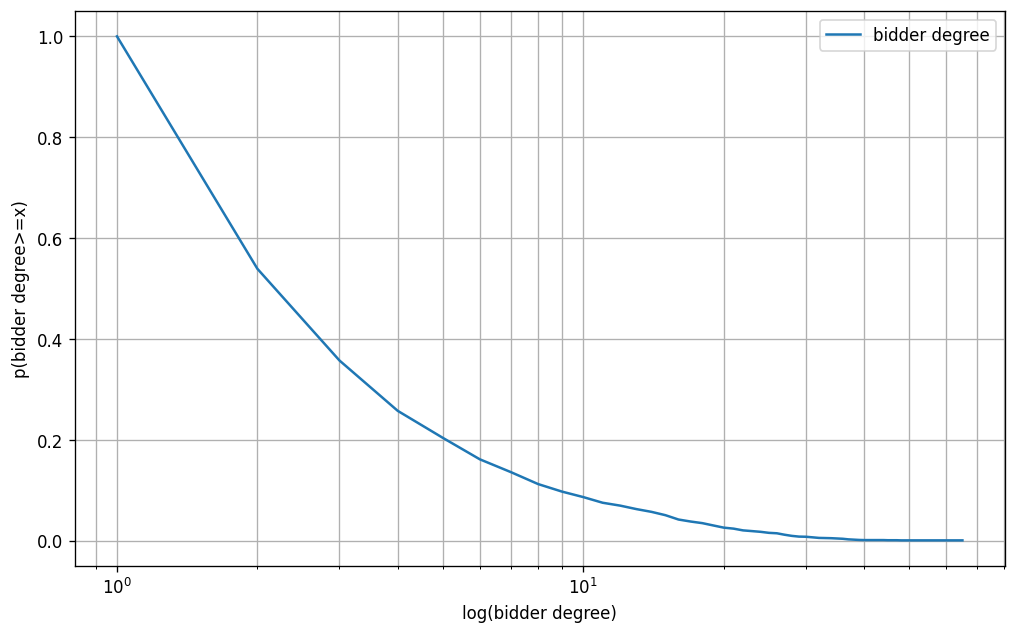

In [59]:
# what is the degree distribution graph of the bidders? ('supplier_name')
# x-axis = degree of node (log scale)
# y-axis = number of nodes with that degree or higher

bidder_degrees = df.groupby("supplier_name")["uge"].nunique().value_counts()

plot_value_distribution(
    bidder_degrees,
    x_log_scale=True,
    y_log_scale=False,
    label="bidder degree",
    fit_curve=False,
)

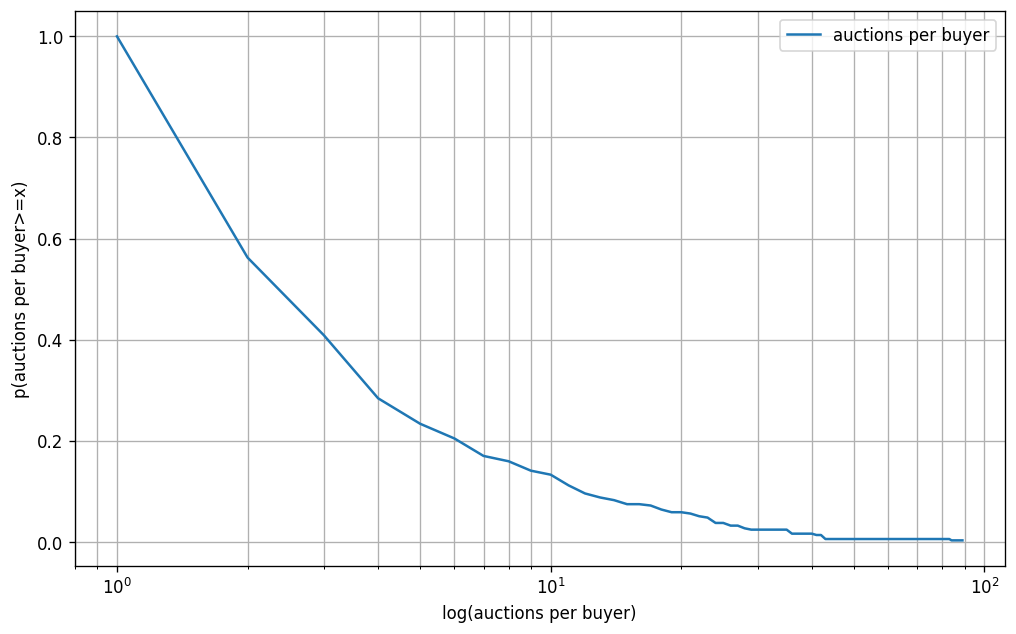

In [60]:
# what is the distribution of number of auctions per buyer? ('uge')

auctions_per_buyer = df.groupby("uge")["id"].nunique().value_counts()

plot_value_distribution(
    auctions_per_buyer,
    x_log_scale=True,
    y_log_scale=False,
    label="auctions per buyer",
    fit_curve=False,
)

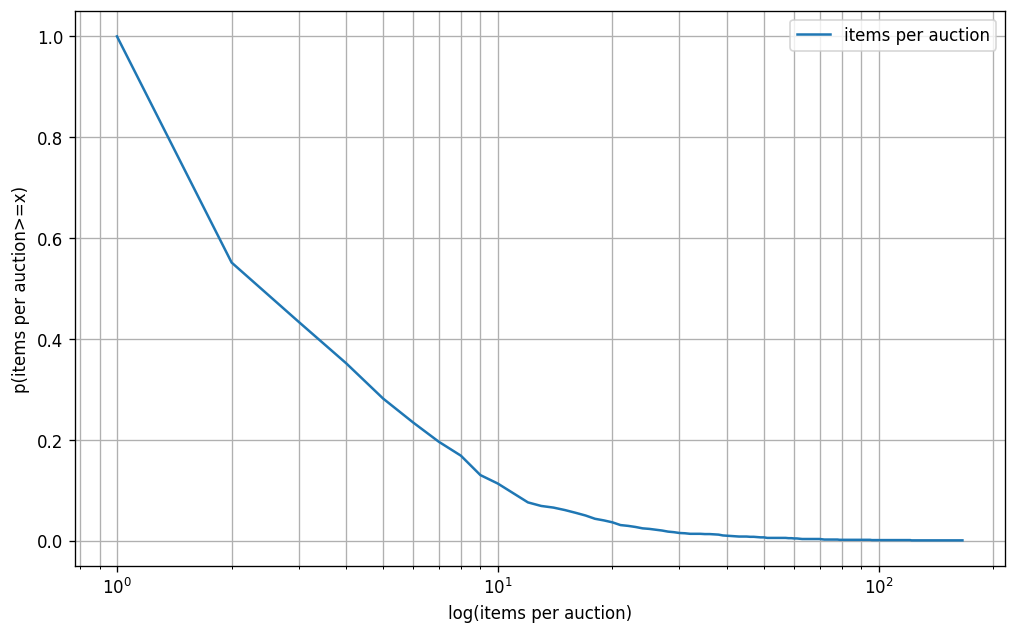

In [61]:
# what is the distribution of items per auction?
# x-axis = number of items
# y-axis = number of auctions

num_items = df.groupby("id")["item"].nunique().value_counts()

num_items = num_items.sort_index()[:300]

plot_value_distribution(
    num_items,
    x_log_scale=True,
    y_log_scale=False,
    label="items per auction",
    fit_curve=False,
)

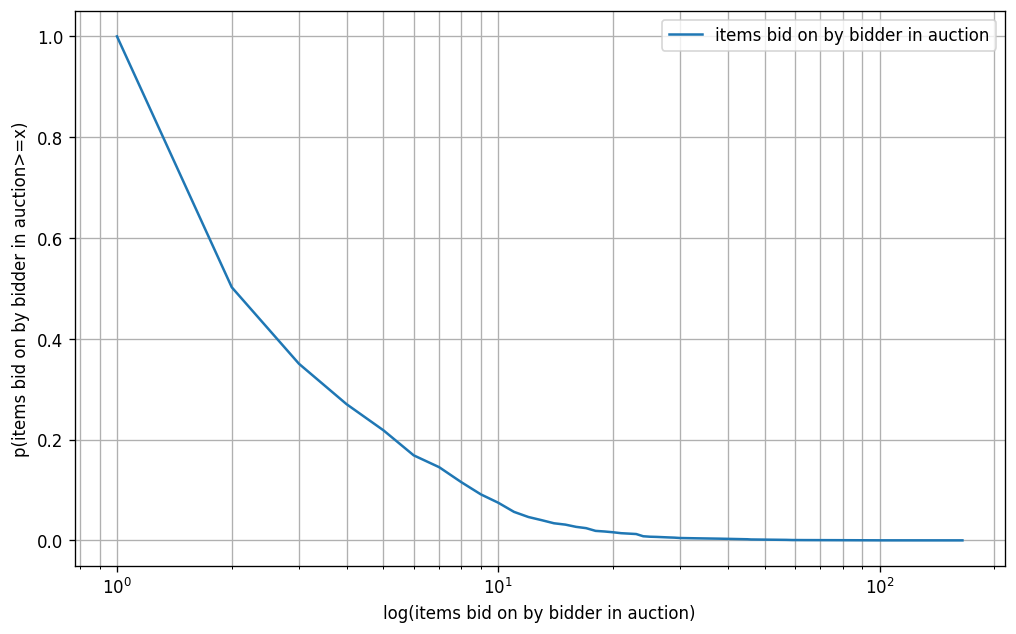

In [62]:
# how often to bidders bid on multiple items in the same auction?

items_bid_on = df.groupby(["id", "supplier_name", "uge"]).item.nunique().value_counts()

plot_value_distribution(
    items_bid_on,
    x_log_scale=True,
    y_log_scale=False,
    label="items bid on by bidder in auction",
    fit_curve=False,
)

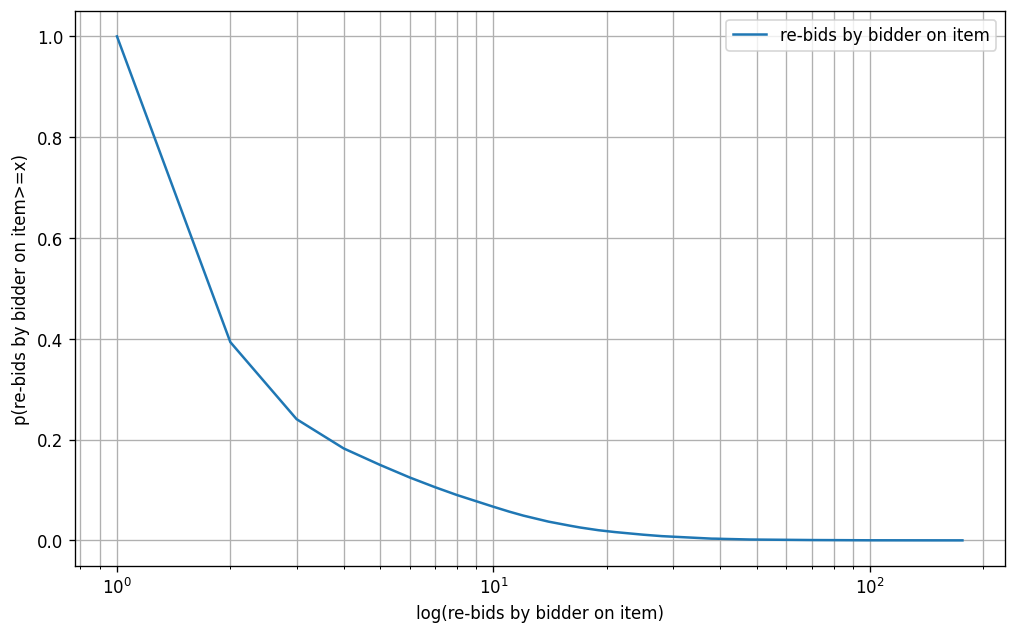

In [63]:
# how often to bidders re-bid on the same item?

rebid = (
    df.groupby(["id", "uge", "supplier_name", "sequence_item"]).size().value_counts()
)

plot_value_distribution(
    rebid,
    x_log_scale=True,
    y_log_scale=False,
    label="re-bids by bidder on item",
    fit_curve=False,
)

In [64]:
# What is the distribution of outcomes for ?

# encerrado com vencedor = finished with winner
# fracassado = failed
# revogado = revoked
# encerrado sem vencedor = finished without winner
# anulado = canceled
df.cr_status.value_counts() / len(df)

cr_status
ENCERRADO COM VENCEDOR    0.948086
FRACASSADO                0.025199
REVOGADO                  0.023127
ENCERRADO SEM VENCEDOR    0.002355
ANULADO                   0.001232
Name: count, dtype: float64

In [66]:
# create a graph of the buyers and bidders, with an edge between them if the bidder has bid on an item from the buyer

# first create a mapping from node id to node name for both buyers and edges
buyer_mapping = dict(enumerate(df.uge.unique()))
bidder_mapping = dict(enumerate(df.supplier_name.unique(), start=len(buyer_mapping)))
item_class_mapping = dict(enumerate(df["class"].unique(), start=max(bidder_mapping.keys())))
item_group_mapping = dict(enumerate(df["group"].unique(), start=max(bidder_mapping.keys())))
# save to csv
pd.DataFrame(buyer_mapping.items(), columns=["uge", "name"]).to_csv(
    "assets/buyer_mapping.csv", index=False
)
pd.DataFrame(bidder_mapping.items(), columns=["supplier_name", "name"]).to_csv(
    "assets/bidder_mapping.csv", index=False
)
pd.DataFrame(item_class_mapping.items(), columns=["class", "name"]).to_csv(
    "assets/item_class_mapping.csv", index=False
)
pd.DataFrame(item_group_mapping.items(), columns=["group", "name"]).to_csv(
    "assets/item_group_mapping.csv", index=False
)

# replace the names with the ids
df["uge"] = df["uge"].map({v: k for k, v in buyer_mapping.items()})
df["supplier_name"] = df["supplier_name"].map({v: k for k, v in bidder_mapping.items()})
df["class"] = df["class"].map({v: k for k, v in item_class_mapping.items()})
df["group"] = df["group"].map({v: k for k, v in item_group_mapping.items()})


In [67]:
# remove 5% of buyer/seller relationships at random 
buyer_supplier_relations = df[["uge", "supplier_name"]].drop_duplicates()
n_relations = buyer_supplier_relations.shape[0]
n_remove = int(n_relations * 0.05)
remove_indices = np.random.choice(n_relations, n_remove, replace=False)

drop_relations = buyer_supplier_relations.iloc[remove_indices]
keep_relations = buyer_supplier_relations.drop(drop_relations.index)

df_keep = df.merge(keep_relations, on=["uge", "supplier_name"], how="inner")
df_drop = df.merge(drop_relations, on=["uge", "supplier_name"], how="inner")

df_drop.shape[0] / df_keep.shape[0]

0.04721667142449329

In [68]:
for (sub_df, name) in [(df_drop, "_dropped"), (df_keep, "")]:
    unique_df = sub_df.drop_duplicates(["uge", "supplier_name"])
    unique_df[["uge", "supplier_name"]].to_csv(
        f"assets/edges_unweighted{name}.csv", index=False, header=False
    )
    print(unique_df.shape)

    # now weighted by number of auctions that they've participated in
    unique_df = sub_df.groupby(["uge", "supplier_name"])['id'].nunique().reset_index()
    unique_df = unique_df.rename({"id": "weight"}, axis=1)
    unique_df[["uge", "supplier_name", "weight"]].to_csv(
        f"assets/edges_weighted{name}.csv", index=False, header=False
    )

(630, 13)
(11984, 13)


In [69]:

from sklearn.preprocessing import MultiLabelBinarizer

# create a sampling table for auction/item. each entry has:
# auction_id, item sequence, item code, buyer, a bidder, onehot encoded buyers that have had that bidder bid on an item in that auction
# this will be used to train a model to predict the outcome of the auction

# for each bidder, get the buyers that they've bid on an item for
bidders_to_buyers = df.groupby("supplier_name")["uge"].unique()
mlb = MultiLabelBinarizer()
onehot_buyers = mlb.fit_transform(bidders_to_buyers)
onehot_buyers = pd.DataFrame(
    onehot_buyers, columns=[f"buyer_{i}" for i in range(onehot_buyers.shape[1])]
)
onehot_buyers.index = bidders_to_buyers.index

for (sub_df, name) in [(df_drop, "_dropped"), (df_keep, "")]:
    unique_df = sub_df[
        ["id", "sequence_item", "class", "uge", "supplier_name"]
    ].drop_duplicates()
    unique_df = unique_df.merge(
        onehot_buyers, how="left", left_on="supplier_name", right_index=True
    )
    unique_df.drop(["id", "sequence_item"], axis=1).astype(int).to_csv(
        f"assets/auction_item_buyer_bidder{name}.csv", index=False
    )

In [70]:
# create a mapping buyer -> other buyers that share a bidder with them

# first create a mapping from buyer to bidders
buyers_to_bidders = df.groupby("uge")["supplier_name"].unique()
# now combine
buyers_to_buyers = {}
for buyer, bidders in buyers_to_bidders.items():
    buyers_to_buyers[buyer] = set()
    for bidder in bidders:
        buyers_to_buyers[buyer].update(bidders_to_buyers.get(bidder, []))
    buyers_to_buyers[buyer].remove(buyer)

In [71]:
import pickle

pickle.dump(buyers_to_buyers, open("assets/buyers_to_buyers.pkl", "wb"))

In [72]:
df_keep.to_csv("assets/processed_data.tsv", sep="\t", index=False)
df_drop.to_csv("assets/processed_data_dropped.tsv", sep="\t", index=False)